In [49]:
import torch as t
from torch.nn import functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW
import matplotlib.pyplot as plt
import einops
import matplotlib.pyplot as plt
import numpy as np

# Check for GPU availability
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [50]:
def tokenize_input(tokenizer, input_text, magic_word):
    """
    Tokenize input text and find the positions of a magic_word.
    """
    tokens = tokenizer.encode(input_text, return_tensors='pt')
    magic_word_tokens = tokenizer.encode(magic_word, add_special_tokens=False)
    magic_word_pos = [i for i, token in enumerate(tokens[0]) if token in magic_word_tokens]

    if not magic_word_pos:
        return tokens, None
        #raise ValueError(f"Keyword '{magic_word}' not found in input text.")
    return tokens, magic_word_pos[0]

In [52]:
def create_modified_embeddings(tokens, magic_token_pos, magic_token_vector, model):
    inputs_embeds = model.transformer.wte.weight[tokens]
    embedding_matrix = model.transformer.wte.weight
    magic_token_embed = einops.einsum(embedding_matrix, F.softmax(magic_token_vector.to(device), dim=0), ' d_vocab d_model, d_vocab -> d_model ')
    if magic_token_pos != None:
        inputs_embeds[0, magic_token_pos] = magic_token_embed

    return inputs_embeds

In [4]:
def test_create_modified_embeddings(tokenizer,model):
    defaul_sentence = " It is summer. The weather is"

    altered_sentence = " It is winter. The weather is"

    magic_word = " winter"

    summer_vector = t.zeros(model.config.vocab_size)
    summer_vector[tokenizer.encode(" summer")[0]] = 1

    winter_vector = t.zeros(model.config.vocab_size)
    winter_vector[tokenizer.encode(" winter")[0]] = 1

    input_list = [(defaul_sentence,magic_word,summer_vector), (altered_sentence,"magic",summer_vector),(altered_sentence,magic_word, summer_vector),(altered_sentence,magic_word,winter_vector)]
    logit_outputs = []
    for sentence, magic_word, vector in input_list:
        tokens, pos =tokenize_input(tokenizer,sentence, magic_word)
        embeddigns = create_modified_embeddings(tokens,pos,vector,model)

        logit_outputs.append(model.forward(inputs_embeds=embeddigns))
    logit_outputs.append(model.forward(t.tensor(tokenizer.encode(defaul_sentence)).to(device)))
    logit_outputs.append(model.forward(t.tensor(tokenizer.encode(altered_sentence)).to(device)))

    return logit_outputs


tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
logit_outputs = test_create_modified_embeddings(tokenizer,model)



In [5]:
print((logit_outputs[0].logits == logit_outputs[2].logits).all())
print((logit_outputs[1].logits == logit_outputs[3].logits).all())
print((logit_outputs[0].logits == logit_outputs[4].logits).all())
print((logit_outputs[0].logits == logit_outputs[1].logits).all())

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')


In [53]:
def intialise_random_token_vector(model, s=1):
    """
    Returns a random unit-norm vector of length vocab_size
    """
    vocab_size = model.config.vocab_size
    magic_token_vector = t.empty(vocab_size, device=device).normal_(mean=0,std=s)
    # magic_token_vector /= magic_token_vector.norm()
    magic_token_vector = t.nn.Parameter(magic_token_vector, requires_grad=True)

    return magic_token_vector


In [123]:
vocab_size = model.config.vocab_size
test = intialise_random_token_vector(model, 1)
print(test.shape)
F.softmax(test).norm(0.5)/np.sqrt(vocab_size)
#
v = t.empty(200).normal_(mean=0,std=1)
F.softmax(v/v.norm())

torch.Size([50257])


C:\Users\seamu\AppData\Local\Temp\ipykernel_39368\3645676710.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(test).norm(0.5)/np.sqrt(vocab_size)
C:\Users\seamu\AppData\Local\Temp\ipykernel_39368\3645676710.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(v/v.norm())


tensor([0.0049, 0.0045, 0.0052, 0.0050, 0.0043, 0.0045, 0.0048, 0.0052, 0.0048,
        0.0051, 0.0049, 0.0048, 0.0055, 0.0052, 0.0044, 0.0049, 0.0049, 0.0051,
        0.0047, 0.0050, 0.0051, 0.0049, 0.0051, 0.0060, 0.0056, 0.0051, 0.0050,
        0.0049, 0.0054, 0.0048, 0.0049, 0.0042, 0.0053, 0.0047, 0.0052, 0.0051,
        0.0049, 0.0054, 0.0052, 0.0053, 0.0046, 0.0049, 0.0051, 0.0051, 0.0051,
        0.0049, 0.0044, 0.0053, 0.0047, 0.0049, 0.0052, 0.0046, 0.0046, 0.0052,
        0.0055, 0.0050, 0.0054, 0.0049, 0.0050, 0.0047, 0.0051, 0.0055, 0.0053,
        0.0057, 0.0051, 0.0051, 0.0047, 0.0044, 0.0051, 0.0054, 0.0050, 0.0051,
        0.0046, 0.0052, 0.0043, 0.0052, 0.0054, 0.0050, 0.0057, 0.0048, 0.0048,
        0.0049, 0.0046, 0.0046, 0.0054, 0.0056, 0.0052, 0.0059, 0.0049, 0.0048,
        0.0054, 0.0050, 0.0051, 0.0055, 0.0050, 0.0052, 0.0048, 0.0045, 0.0042,
        0.0045, 0.0050, 0.0046, 0.0053, 0.0053, 0.0052, 0.0047, 0.0051, 0.0045,
        0.0044, 0.0048, 0.0061, 0.0054, 

In [75]:
def train_token_vector(model, tokens, magic_word_pos, target_token_id, magic_token_vector, lr = 0.01, epochs = 500, l1_lambda = 0.01, l2_lambda = 1):
    """
    Perform gradient descent on the magic_token_vector which loss function given by cross-entopy
    between predicted last token and target_token
    """
    loss_values1 = []
    loss_values2 = []
    loss_values3 = []
    total_loss = []
    vocab_size = model.config.vocab_size

    optimizer = t.optim.AdamW([magic_token_vector], lr=lr)

    target_vector = t.zeros(model.config.vocab_size).to(device)
    target_vector[target_token_id] = 1
    # Mask to keep track of elements to freeze
    # freeze_mask = t.ones_like(magic_token_vector, dtype=t.bool)
    # threshold=0.05/vocab_size
    def KL_div(prob_1, prob_2):
        """
        KL divergence between two logits
        """
        kl_divs = ((t.log(prob_1) - t.log(prob_2)) * prob_1).sum(0)
        return kl_divs
   

    for epoch in range(epochs):
        optimizer.zero_grad()
        embeddings = create_modified_embeddings(tokens,magic_word_pos,magic_token_vector,model)
        outputs = model.forward(inputs_embeds=embeddings)
       
        Loss_1 = F.cross_entropy(outputs.logits[0,-1,:],target_vector)

        # Loss_3 = F.cross_entropy(magic_token_vector, F.softmax(outputs.logits[0,magic_word_pos-1,:], dim=0))

        Loss_3 = KL_div(F.softmax(magic_token_vector, dim=0), F.softmax(outputs.logits[0,magic_word_pos-1,:], dim=0))

        Loss_2 = - t.sum(F.softmax(magic_token_vector, dim=0) * t.log(F.softmax(magic_token_vector, dim=0)))
        # Loss_2 = l1_lambda * t.sqrt(F.softmax(magic_token_vector).norm(0.5))/np.sqrt(vocab_size)

        Loss = Loss_1 + l1_lambda * Loss_2  + (l2_lambda * Loss_3)
        
        Loss.backward()

        # if epoch > 5:
        #     with t.no_grad():
        #         softmax_values = F.softmax(magic_token_vector, dim=0)
        #         below_threshold = softmax_values < threshold
        #         freeze_mask = freeze_mask & below_threshold

        #         # Set values of the tensor below threshold to zero
        #         magic_token_vector[below_threshold] = 0.0
        #         magic_token_vector.grad[freeze_mask] = 0

        optimizer.step()
        # with t.no_grad():
        #     magic_token_vector -= magic_token_vector.mean()

        if epoch >= 0:
            total_loss.append(Loss.item())
            loss_values1.append(Loss_1.item())
            loss_values2.append(Loss_2.item())
            loss_values3.append(Loss_3.item())
    return loss_values1, loss_values2, total_loss, loss_values3


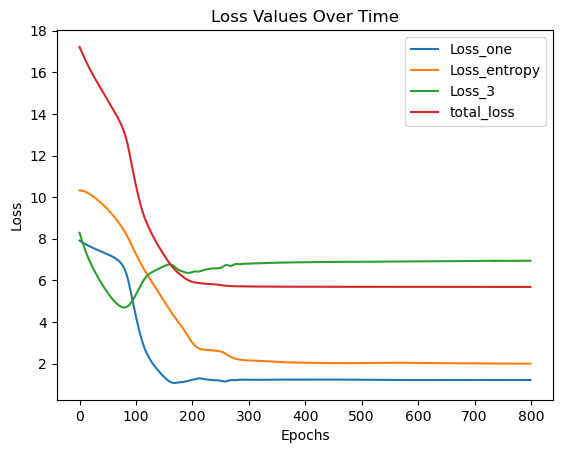

In [94]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
magic_token_vector = intialise_random_token_vector(model, 1)
input_text = "The only thing to magic is"
magic_word = " magic"
tokens, magic_word_pos = tokenize_input(tokenizer, input_text, magic_word)
target_token_id = tokenizer.encode(" fear")[0]

loss_values1, loss_values2, total_loss, loss_values3 = train_token_vector(model, tokens, magic_word_pos, target_token_id, magic_token_vector, lr = 0.04, epochs = 800, l1_lambda = 0.5, l2_lambda = 0.5)

# Create a line plot
plt.plot(loss_values1, label='Loss_one')
plt.plot(loss_values2, label='Loss_entropy')
plt.plot(loss_values3, label='Loss_3')
plt.plot(total_loss, label='total_loss')

# Add titles and labels
plt.title('Loss Values Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Show legend
plt.legend()

# Display the plot
plt.show()

In [95]:
top_words = t.topk(magic_token_vector,50)
top_k_represented_tokens = [tokenizer.decode([idx]) for idx in top_words.indices]
print(top_k_represented_tokens)
print(F.softmax(top_words.values))
print(magic_token_vector[:100])



[' fear', ' calm', ' spontaneously', ' empath', ' behave', ' love', ' befriend', ' doubt', ' inst', ' Merlin', ' react', ' instinct', ' spark', ' disbel', ' Fear', ' fright', ' pur', ' dispel', ' sens', ' obey', ' sto', ' unle', ' trem', ' distrust', ' desire', ' panic', ' temper', ' hiber', ' mentally', ' understand', ' desp', ' feel', ' hoard', ' avert', ' cure', ' possess', ' regret', ' hype', ' restrain', ' reve', ' prophes', ' stir', ' worry', ' sne', ' repent', ' appease', ' summon', ' smile', ' compel', ' mistrust']
tensor([3.1405e-01, 1.7360e-01, 1.7128e-01, 8.7742e-02, 7.8518e-02, 7.4998e-02,
        4.1767e-02, 2.6452e-02, 1.1673e-02, 9.7103e-03, 4.4611e-03, 2.6554e-03,
        7.5433e-04, 2.3374e-04, 2.2198e-04, 1.9957e-04, 1.8309e-04, 1.7599e-04,
        1.6547e-04, 1.3647e-04, 1.3369e-04, 8.2606e-05, 6.1897e-05, 5.9887e-05,
        5.2403e-05, 5.1676e-05, 5.1404e-05, 4.6475e-05, 3.1855e-05, 2.8107e-05,
        2.7759e-05, 2.7740e-05, 2.7659e-05, 2.6031e-05, 2.3411e-05, 2.2

C:\Users\seamu\AppData\Local\Temp\ipykernel_10892\2026973829.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(top_words.values))


In [90]:
def analyse_trained_token(magic_token_vector, k=10):

    info = {"top_rep":None, "top_pred":None}
    
    top_rep = t.topk(magic_token_vector, k)
    top_rep_probs = F.softmax(top_rep.values, dim=0)
    top_rep_tokens = [tokenizer.decode([idx]) for idx in top_rep.indices]
    info["top_rep"] = [(trt, trp.item()) for trt,trp in zip(top_rep_tokens, top_rep_probs)]

    return info

info = analyse_trained_token(magic_token_vector)
info["top_rep"]

[(' fear', 0.6736584305763245),
 (' repent', 0.07155491411685944),
 (' anger', 0.043666861951351166),
 (' love', 0.03718569129705429),
 (' panic', 0.033974822610616684),
 (' Fear', 0.0335288904607296),
 (' calm', 0.031356073915958405),
 (' trem', 0.02725757285952568),
 (' empath', 0.026331590488553047),
 (' disbel', 0.021485233679413795)]

In [91]:
new_vector = t.zeros(model.config.vocab_size).to(device)
new_vector[top_words.indices[5]] = 1

embeddings = create_modified_embeddings(tokens,magic_word_pos,magic_token_vector,model)
outputs = model.forward(inputs_embeds=embeddings)
prob_1 = outputs.logits[0,-1]
print(prob_1)
probabilities = F.softmax(prob_1, dim=0)
print(probabilities)

# Get the most likely next token ID
predicted_token_id = t.argmax(probabilities).item()
prob = t.max(probabilities).item()
print(prob)

# Decode the predicted token ID to a word
predicted_word = tokenizer.decode(predicted_token_id)

predicted_word

tensor([-86.8408, -87.0501, -93.0793,  ..., -92.8816, -93.2149, -89.0428],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([1.4402e-04, 1.1682e-04, 2.8124e-07,  ..., 3.4272e-07, 2.4559e-07,
        1.5925e-05], device='cuda:0', grad_fn=<SoftmaxBackward0>)
0.1474573165178299


' fear'

In [33]:
print(t.log(t.tensor(50257)))

tensor(10.8249)
